## AllLife Bank Customer Segment

### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Data Discription

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).



### Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Libraries

In [1]:
! pip install yellowbrick
! pip install tabulate

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs


# to visualize the elbow curve and silhouette scores

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

# to perform PCA
from sklearn.decomposition import PCA

# Pandas dataframe options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth',400)


# set the background for the graphs
plt.style.use('ggplot')

# For pandas profiling
# from pandas_profiling import ProfileReport

# Printing style
from tabulate import tabulate

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install openpyxl

### Loading the Dataset

In [4]:
cc_data = pd.read_excel("Credit+Card+Customer+Data.xlsx")

In [5]:
data = cc_data.copy()

### Dataset Summary

#### Shape of the data

In [6]:
print('There are {row} records, and {col} columns in the dataset'.format(row=data.shape[0], col=data.shape[1]))

There are 660 records, and 7 columns in the dataset


### Missing Values

In [7]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no missing values in the dataset

### Duplicate data

In [8]:
data.duplicated().sum()

0

There are no duplicate records

### Sample records

In [9]:
data.sample(10)

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
245    246         81531             10000                   4   
71      72         35149              6000                   3   
342    343         38244              9000                   6   
23      24         61061              9000                   1   
410    411         45808             40000                   5   
328    329         26678             14000                   4   
498    499         22842             31000                   4   
353    354         94437              9000                   5   
559    560         81510             41000                   7   
565    566         26063             69000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
245                  2                    1                 0  
71                   2                    2                 7  
342                  4                    2                 3  
23                   1                    3                 4  
410                  2                    2                 2  
328                  4                    2                 1  
498                  4                    1                 0  
353                  4                    1                 3  
559                  5                    2                 3  
565                  5                    0                 1

#### Data Types

In [10]:
data.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

All the attributes are integers

### Checking keys

There are only one possible attribute for key, the Customer Key. We'll first convert the Sl_No to index, and then check the Customer Key. Since this data is to be used for customer segmentation, findig the customer key is essential.

I have already checked this in excel, hence depicting the same in the notebook. Considering the small size of the dataset, is it really convenient to check a few initial things in the excel file itself first.

In [11]:
data = data.set_index(['Sl_No'])

In [12]:
data.index.max()

660

In [13]:
data['Customer Key'].nunique()

655

There appears to be 5 duplicates in the customer key

### Analyzing the records with duplicate customer keys

In [14]:
data[data['Customer Key'].isin(data[data['Customer Key'].duplicated()]['Customer Key'].tolist())].sort_values('Customer Key')

Customer Key  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Sl_No                                                                          
49            37252              6000                   4                  0   
433           37252             59000                   6                  2   
5             47437            100000                   6                  0   
333           47437             17000                   7                  3   
412           50706             44000                   4                  5   
542           50706             60000                   7                  5   
392           96929             13000                   4                  5   
399           96929             67000                   6                  2   
105           97935             17000                   2                  1   
633           97935            187000                   7                  1   

       Total_visits_online  Total_calls_made  
Sl_No                                         
49                       2                 8  
433                      1                 2  
5                       12                 3  
333                      1                 0  
412                      0                 2  
542                      2                 2  
392                      0                 0  
399                      2                 2  
105                      2                10  
633                      7                 0

The records for same Customer Key look really different from each other. I am assuming this is either mistake in the Customer Key assignment, or we are missing current_version_indicator in the dataset. As of now, I am going to consider these as two different customers. After the clustering, I will analyze the groups corresponding to these sets of records

### Standardizing Column Names

In [15]:
def feature_name_standardize(df: pd.DataFrame):
    df_ = df.copy()
    df_.columns = [i.replace(" ", "_").lower() for i in df_.columns]
    return df_

In [16]:
data = feature_name_standardize(data)

### Column Statistinc

In [17]:
data.describe().T

count      mean       std       min       25%       50%  \
customer_key        660.000 55141.444 25627.772 11265.000 33825.250 53874.500   
avg_credit_limit    660.000 34574.242 37625.488  3000.000 10000.000 18000.000   
total_credit_cards  660.000     4.706     2.168     1.000     3.000     5.000   
total_visits_bank   660.000     2.403     1.632     0.000     1.000     2.000   
total_visits_online 660.000     2.606     2.936     0.000     1.000     2.000   
total_calls_made    660.000     3.583     2.865     0.000     1.000     3.000   

                          75%        max  
customer_key        77202.500  99843.000  
avg_credit_limit    48000.000 200000.000  
total_credit_cards      6.000     10.000  
total_visits_bank       4.000      5.000  
total_visits_online     4.000     15.000  
total_calls_made        5.000     10.000

### Exploratory Data Analysis

### Univariate Analysis

The first step of univariate analysis is to check the distribution/spread of the data. This is done using primarily **histograms** and **box plots**. Additionally we'll plot each numerical feature on violin plot and **cumulative density distribution plot**. For these 4 kind of plots, we are building below **summary()** function to plot each of the numerical attributes. Also, we'll display feature-wise **5 point summary**.

In [18]:
def summary(data: pd.DataFrame, x: str):
    '''
    The function prints the 5 point summary and histogram, box plot, 
    violin plot, and cumulative density distribution plots for each 
    feature name passed as the argument.
    
    Parameters:
    ----------
    
    data: pd.Datafraame, the dataset
    x: str, feature name
    
    Usage:
    ------------
    
    summary(data, 'age')
    '''
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    
    dict={'Min': x_min, 'Q1': Q1, 'Q2': Q2, 'Q3': Q3, 'Max': x_max}
    df = pd.DataFrame(data=dict, index=['Value'])
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n')
    print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('Pastel1')
    
    plt.subplot(221, frameon=True)
    ax1 = sns.distplot(data[x], color = 'purple')
    ax1.axvline(
        np.mean(data[x]), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax1.axvline(
        np.median(data[x]), color="black", linestyle="-"
    )  # Add median to the histogram
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222, frameon=True)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223, frameon=True, sharex=ax1)
    ax3 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6, showmeans=True)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224, frameon=True, sharex=ax2)
    ax4 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()

In [19]:
print('We will check the summary of below columns: \n', data.columns.tolist())


We will check the summary of below columns: 
 ['customer_key', 'avg_credit_limit', 'total_credit_cards', 'total_visits_bank', 'total_visits_online', 'total_calls_made']


### Summary of Avergae Credit Limit

5 Point Summary of Avg_credit_limit Attribute:

+-------+-------+-------+-------+-------+--------+
|       |   Min |    Q1 |    Q2 |    Q3 |    Max |
|-------+-------+-------+-------+-------+--------|
| Value |  3000 | 10000 | 18000 | 48000 | 200000 |
+-------+-------+-------+-------+-------+--------+


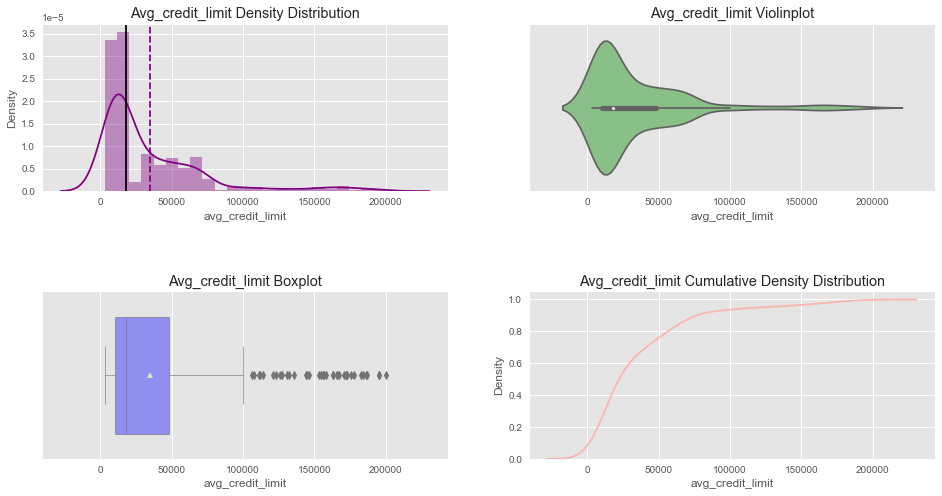

In [20]:
summary(data, 'avg_credit_limit')

The attribute is **right skewed** with a lot of **outliers**

### Summary of Total Number of Credit Cards

5 Point Summary of Total_credit_cards Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     1 |    3 |    5 |    6 |    10 |
+-------+-------+------+------+------+-------+


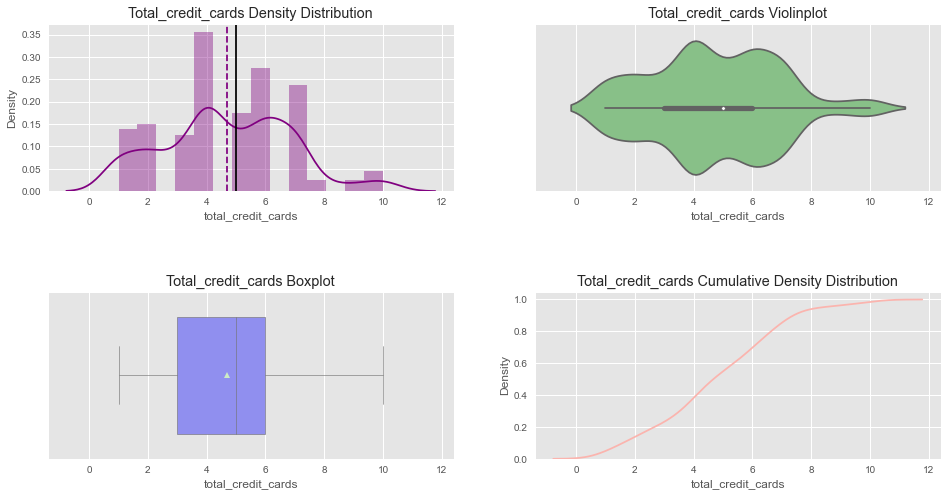

In [21]:
summary(data, 'total_credit_cards')

The attribute is fairly normally distributed with a few spikes

### Summary of Total Number of Visits to the Bank

5 Point Summary of Total_visits_bank Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    4 |     5 |
+-------+-------+------+------+------+-------+


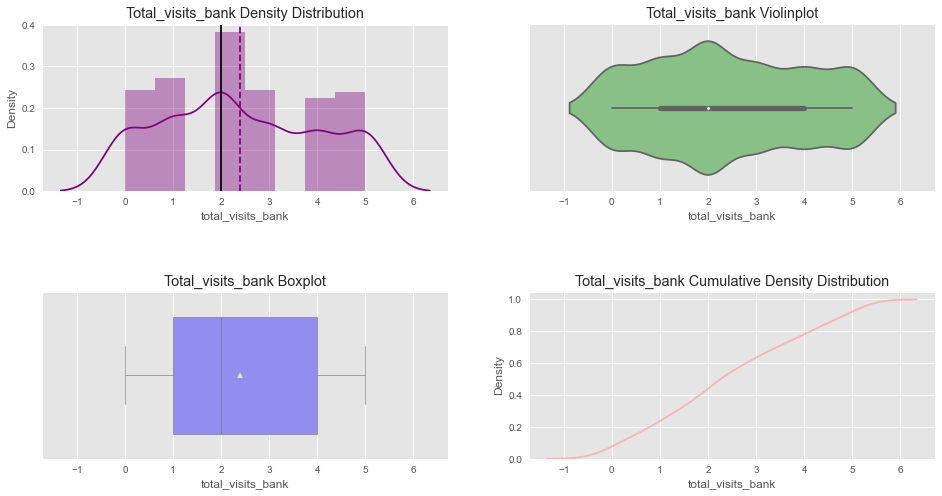

In [22]:
summary(data, 'total_visits_bank')

The data is slightly **right skewed**

### Summary of Total Online Visits

5 Point Summary of Total_visits_online Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    4 |    15 |
+-------+-------+------+------+------+-------+


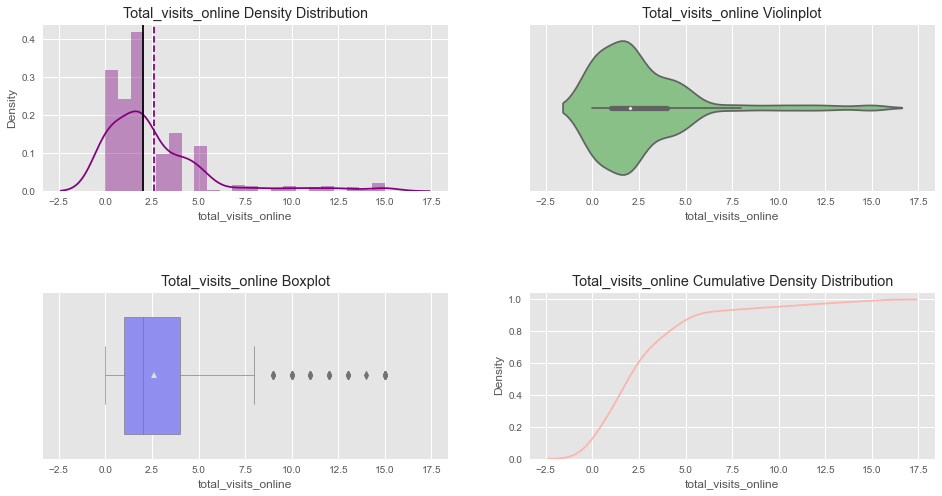

In [23]:
summary(data, 'total_visits_online')

The data is **right skewed** and has some **outliers** to the right

### Summary of Total Calls Made to the Bank

5 Point Summary of Total_calls_made Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    3 |    5 |    10 |
+-------+-------+------+------+------+-------+


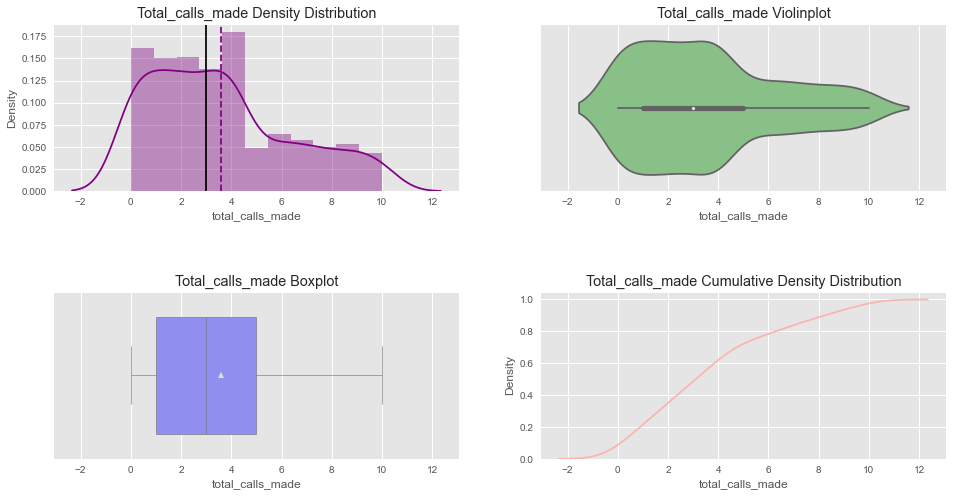

In [24]:
summary(data, 'total_calls_made')

The data is **right skewed**

### Labeled Bar-plots

Creating a function to plot labeled bar plot of the features, with percentage label on data bars.

In [25]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 3))
    else:
        plt.figure(figsize=(n + 1, 3))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

Creating a credit card limit bin out of the available data in the avg credit limit feature

In [26]:
data['cc_spending_bin'] = pd.cut(data['avg_credit_limit'], bins=[3000,	10000,	18000, 	48000,	200000]
                                ,labels=['Very Low', 'Low', 'Mid', 'High'], include_lowest=True)


### Credit Card Limit Bins

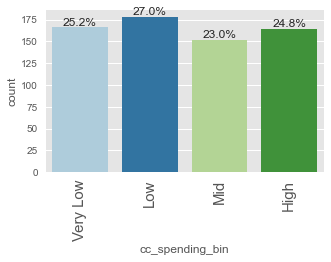

In [27]:
labeled_barplot(data, 'cc_spending_bin', perc=True)

### Total Credit Cards

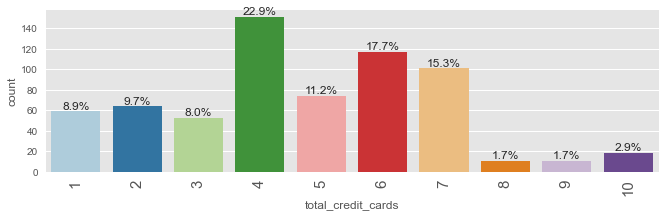

In [28]:
labeled_barplot(data, 'total_credit_cards', perc=True)

### Total Visits to the Bank

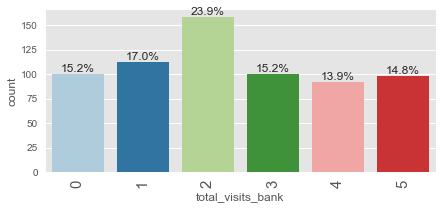

In [29]:
labeled_barplot(data, 'total_visits_bank', perc=True)

### Total Online Visits

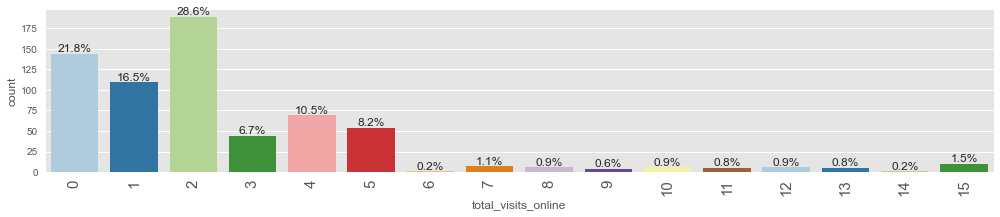

In [30]:
labeled_barplot(data, 'total_visits_online', perc=True)

### Total Calls Made

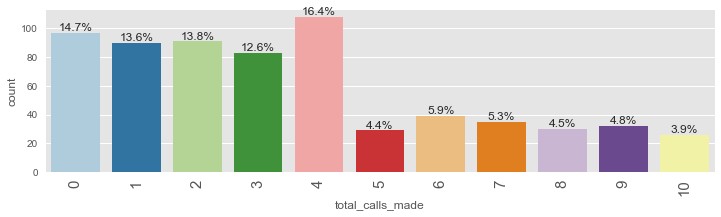

In [31]:
labeled_barplot(data, 'total_calls_made', perc=True)

### Bi-variate Analysis

### Pair Plot

<Figure size 1440x1440 with 0 Axes>

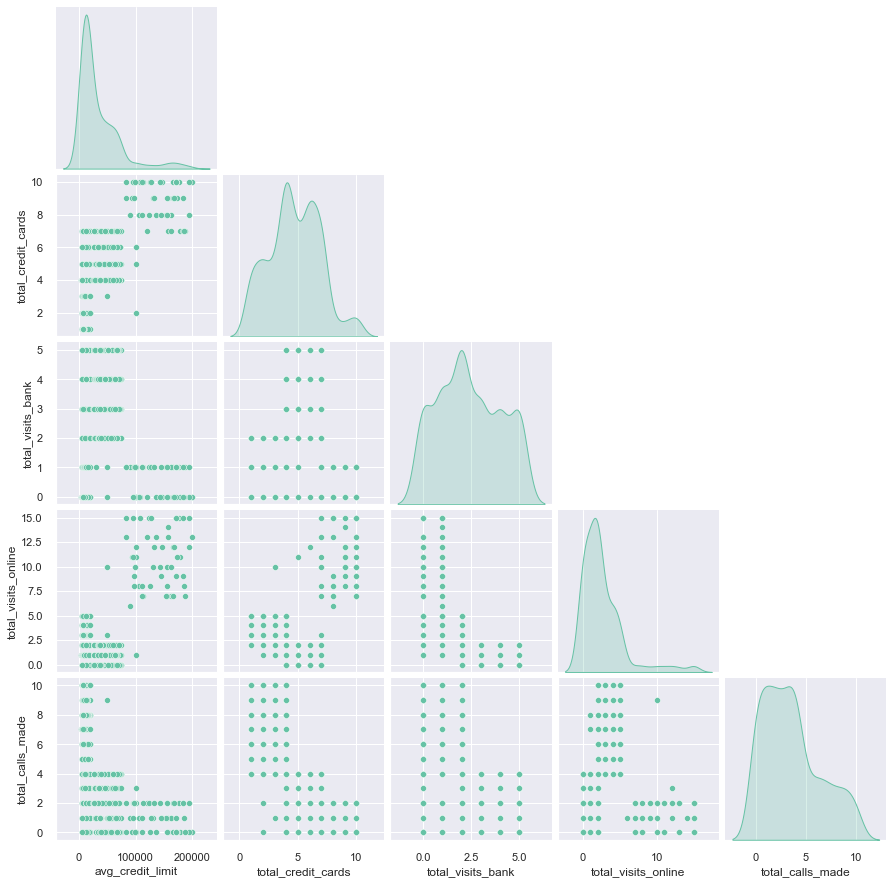

In [32]:
plt.figure(figsize=(20,20));
sns.set(palette="Set2");
sns.pairplot(data.iloc[:, 1:], diag_kind='kde', corner=True);

### Heatmap

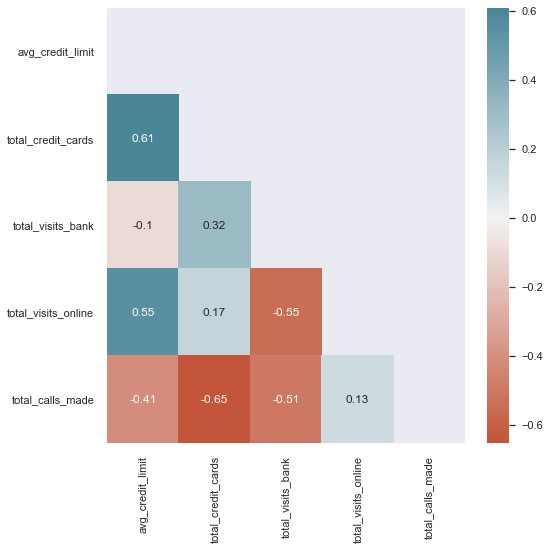

In [33]:
# Plotting correlation heatmap of the features

mask = np.zeros_like(data.iloc[:, 1:].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.set(rc={"figure.figsize": (8, 8)})

sns.heatmap(
    data.iloc[:, 1:].corr(),
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    mask=mask,
    center=0,
)
plt.show()

* Average Credit Limit has slightly positive correlation with Total Credit Cards (obviously) and Total Number of Visits Online, and slightly negative correlation with Total Calls Made
* Total Credit Cards and Total Calls Made are negatively correlated
* Total Visits Online is also negatively correlated with Total Visits to Bank

### Average Credit Limit distribution by Each of the Other Attributes

In [34]:
# Function to plot numerical feature by each category with target hue

def plot_numeric_by_cat(data: pd.DataFrame, category_columns: list, numeric_column: str, hue: str = None):
    '''
    The function plots a numerical feature in box plot by every category column specified in the list, 
    with hue of a target category
    '''
    num_cols = 2
    num_rows = int(len(category_columns) /2 + 1)

    plt.figure(figsize=(20, 8*num_rows))
    for i, col in enumerate(category_columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.set(palette="nipy_spectral");
        sns.boxplot(data=data, x=col, y=numeric_column, hue=hue, showfliers=True).set(title = numeric_column + ' vs. ' + col );

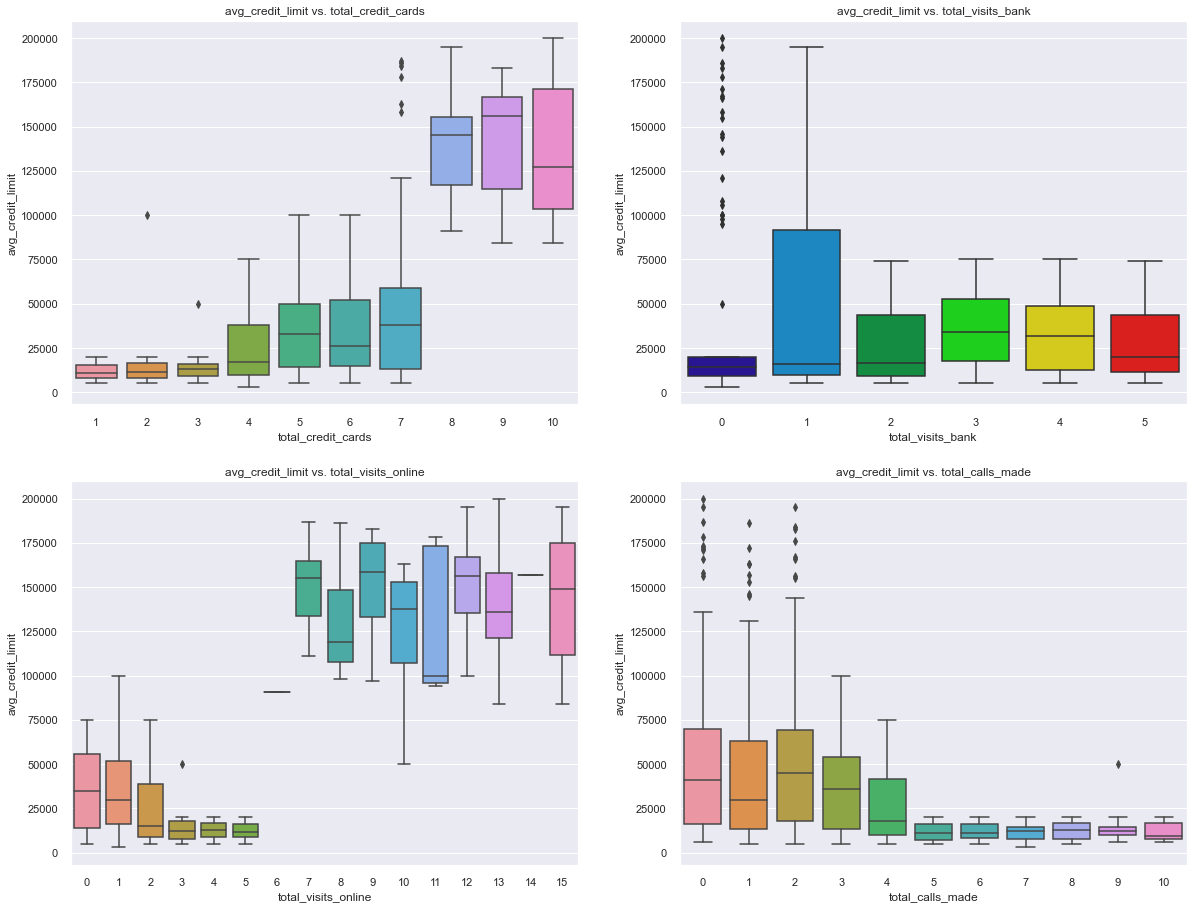

In [35]:
plot_numeric_by_cat(data\
                    ,category_columns=['total_credit_cards', 'total_visits_bank', 'total_visits_online', 'total_calls_made']\
                    ,numeric_column='avg_credit_limit')

We can see clear segmentations with respect to each pair of features

### Data Preprocessing

Before clustering, we should always scale the data, because, different scales of features would result in unintentional importance to the feature of higher scale while calculating the distances.

In [36]:
# scaling the dataset before clustering
data_copy = data.copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:,1:-1])

## K-means Clustering

K-means is often referred to as Lloyd’s algorithm. In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose samples from the dataset . After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.

### Finding the best numbr of centroids (K)

#### Elbow Curve to get the right number of Clusters

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

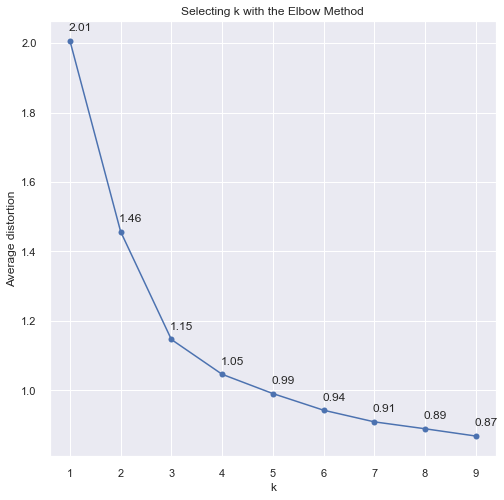

In [37]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(data_scaled)
    prediction = model.predict(data_scaled)
    distortion = (
        sum(
            np.min(cdist(data_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / data_scaled.shape[0]
    )

    meanDistortions.append(distortion)


plt.plot(clusters, meanDistortions, "bo-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
for x,y in zip(clusters, meanDistortions):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Appropriate value for k seems to be 3

#### Silhouette Scores

silhouette score=𝑝−𝑞𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

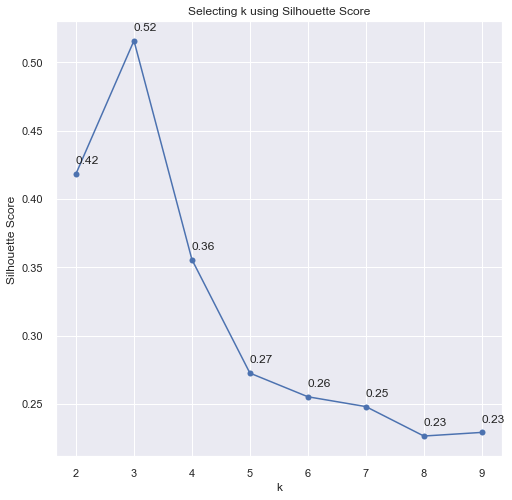

In [38]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((data_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_scaled, preds)
    sil_score.append(score)
    

plt.plot(cluster_list, sil_score, "bo-")
plt.xlabel("k")
plt.ylabel("Silhouette Score ")
plt.title("Selecting k using Silhouette Score")
for x,y in zip(cluster_list, sil_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Silhouette score for 3 clusters is highest. So, we will choose 3 as value of k.

Let's also visualize the silhouettes created by each of the clusters for two values of K, 3 and 4


### Visualize the Silhouettes

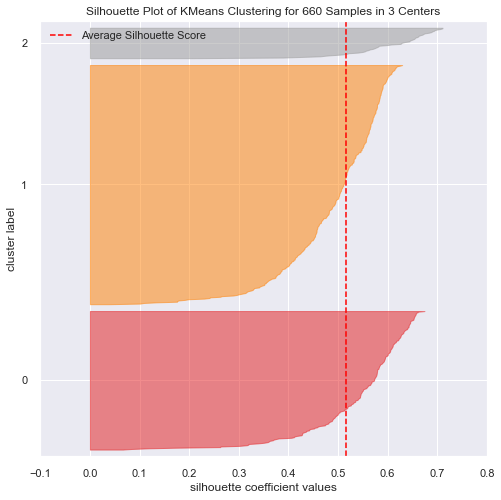

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

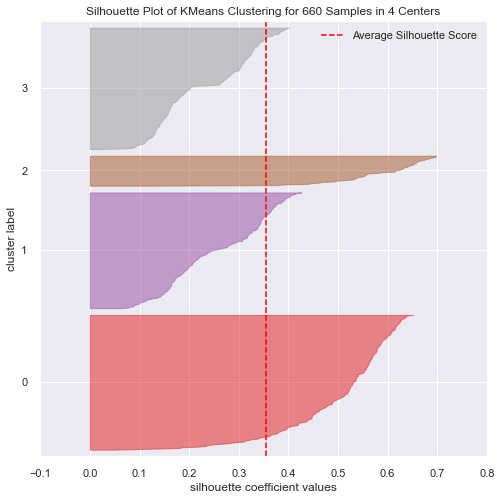

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [40]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

Clearly, 3 clusters seem very reasonable 

### Build the model with 3 centroids

In [41]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=0)

### Add the cluster numbers as a new attribute in the dataset

In [42]:
# adding kmeans cluster labels to the original and scaled dataframes
data_scaled_df = pd.DataFrame(data_scaled, columns=data.iloc[:,1:-1].columns.unique().tolist())
data['cluster'] = kmeans.labels_
data_scaled_df['cluster'] = kmeans.labels_

### Customer Profiling - Visualize the Clusters with Features

<Figure size 1440x1872 with 0 Axes>

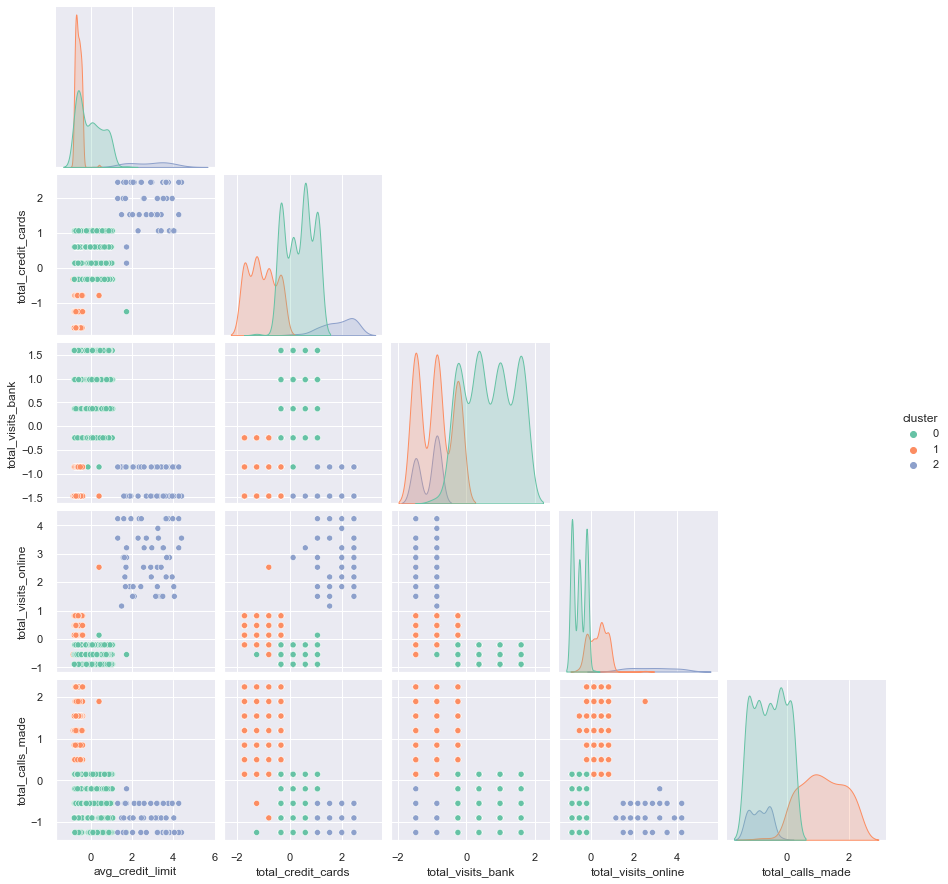

In [43]:
plt.figure(figsize=(20, 26))

sns.pairplot(data_scaled_df, diag_kind='kde', corner=True, hue='cluster', palette='Set2');

It appears, the **method of contacting the bank (In Person/ Online/ Call)** drives the clustering mechanism predominantly, explore this in below plot

In [44]:
! pip install plotly
import plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x= data['total_visits_bank'],
    y= data['total_visits_online'],
    z= data['total_calls_made'],
    mode='markers',
     marker=dict(
        color = data['cluster'], 
        size= 20,
        line=dict(
            color= data['cluster'],
            width= 12
        ),
        opacity=0.8
     ),

)
d = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Bank Visits'),
            yaxis = dict(title  = 'Online Visits'),
            zaxis = dict(title  = 'Call Customer Service')
        )
)
fig = go.Figure(data=d, layout=layout)
py.offline.iplot(fig)

<AxesSubplot:xlabel='avg_credit_limit', ylabel='total_credit_cards'>

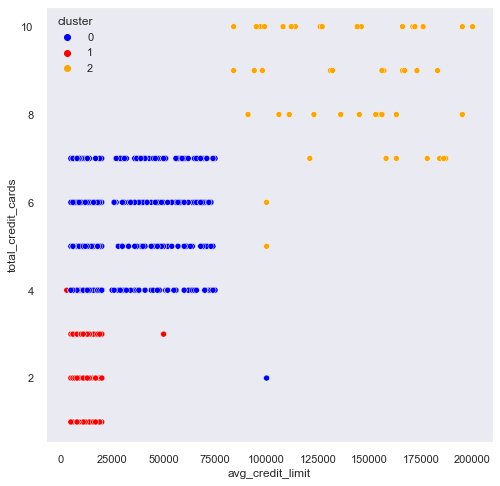

In [45]:
sns.set(style='dark')
sns.scatterplot(x=data['avg_credit_limit'], y=data['total_credit_cards'], hue=data['cluster'], palette=['blue', 'red', 'orange'])

### Clusters Obtained from K-Means technique:

In [46]:
cluster_profile = data.iloc[:,1:].groupby('cluster').mean()
cluster_profile['count_of_customers'] = data.groupby('cluster')['customer_key'].count()

cluster_profile.style.highlight_max(color='lightgreen').highlight_min(color='pink')

### Analyzing the segments using Box Plot

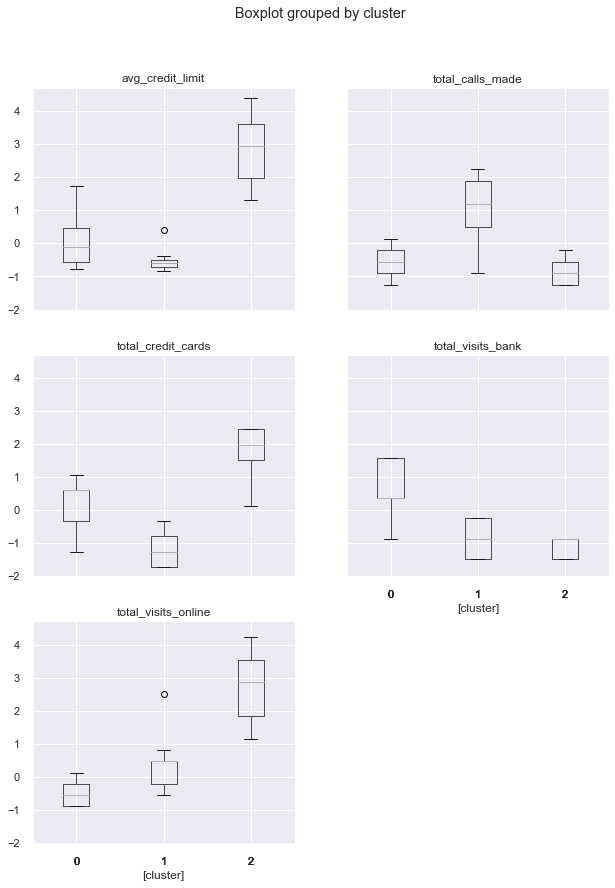

In [47]:
data_scaled_df.boxplot(by='cluster', layout=(3,2), figsize=(10,14));

* If we look at the data we see that there is a group which prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards (cluster - 2).
* The customers who prefer in-person interactions tend to have the mid-range of credit cards and credit limit (cluster - 0).
* The customers who contact via phonecall are in another segment, who have lowest credit limit and number of cards (cluster - 1).

## Hierarchical Clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

**Ward** minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

**Maximum or complete linkage** minimizes the maximum distance between observations of pairs of clusters.

**Average linkage** minimizes the average of the distances between all observations of pairs of clusters.

**Single linkage** minimizes the distance between the closest observations of pairs of clusters.

Before starting clustering we'll remove the cluster column from the dataset.

In [48]:
k_means_clusters = data_scaled_df['cluster']
data_scaled_df.drop(columns=['cluster'], inplace=True)

I am going to try many distance metrics and linkage methods to find the best combination.

### Cophenetic Correlations

The cophenetic correlation for a cluster tree is defined as the linear correlation coefficient between the cophenetic distances obtained from the tree, and the original distances (or dissimilarities) used to construct the tree. Thus, it is a measure of how faithfully the tree represents the dissimilarities among observations.

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.

The magnitude of this value should be very close to 1 for a high-quality solution. This measure can be used to compare alternative cluster solutions obtained using different algorithms.

In [49]:
# list of distance metrics
distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'euclidean', 'hamming', 'jaccard', 'mahalanobis', 'matching', 'minkowski', 'seuclidean',  'sqeuclidean']

# list of linkage methods
linkage_methods = ['complete', 'average', 'single', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Braycurtis distance and complete linkage is 0.5082233975395475.
Cophenetic correlation for Braycurtis distance and average linkage is 0.6052152783444972.
Cophenetic correlation for Braycurtis distance and single linkage is 0.8502845518924395.
Cophenetic correlation for Braycurtis distance and weighted linkage is 0.531818336516011.
Cophenetic correlation for Canberra distance and complete linkage is 0.46069443891594597.
Cophenetic correlation for Canberra distance and average linkage is 0.6751521558776901.
Cophenetic correlation for Canberra distance and single linkage is 0.7566178713003985.
Cophenetic correlation for Canberra distance and weighted linkage is 0.5351232761249246.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlat

In [50]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389373, which is obtained with average linkage.


 The cophenetic correlation is maximum with **Euclidean distance** and **Average Linkage**.

### Dendograms

A dendrogram, in general, is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters.

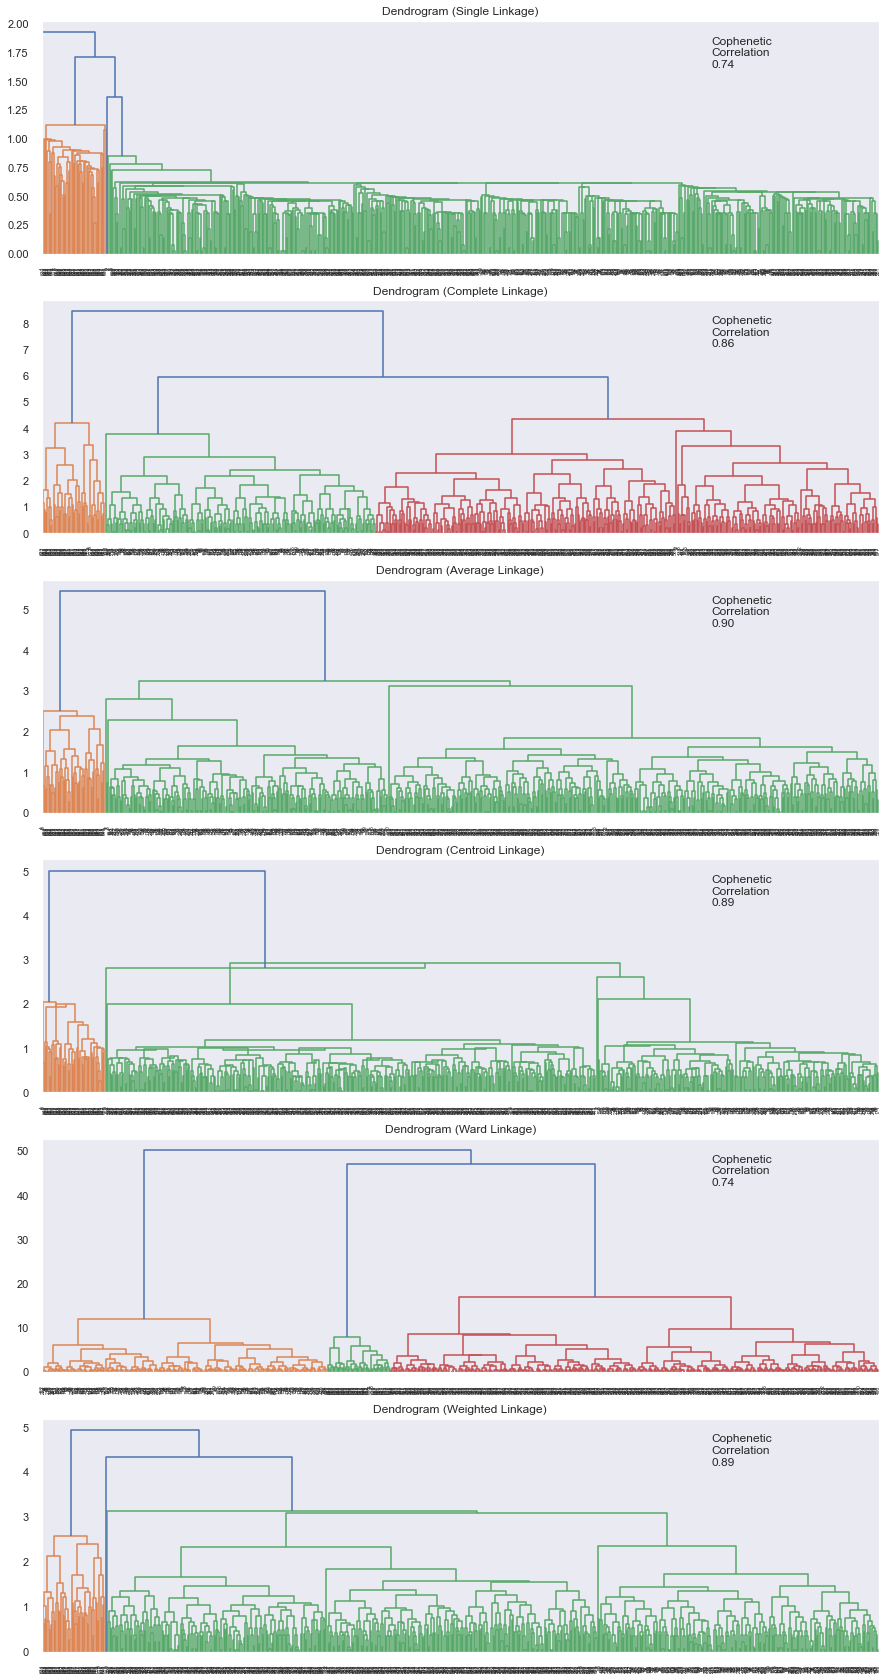

In [51]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

The **cophenetic correlation** is **highest** for **average linkage methods**.
**3** appears to be the appropriate **number of clusters** from the dendrogram for average linkage

### Build Agglomerative Clustering model

Also known as bottom-up approach or hierarchical agglomerative clustering (HAC). Bottom-up algorithms treat each data as a singleton cluster at the outset and then successively agglomerates pairs of clusters until all clusters have been merged into a single cluster that contains all data.

### Build Model

In [52]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(data_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

### Assign cluster labels

In [53]:
data_scaled_df['hc_cluster'] = HCmodel.labels_
data['hc_cluster'] = HCmodel.labels_

### Clusters Obtained from  hierarchical technique:
### Cluster profile

In [54]:
cluster_profile_hc = data.iloc[:,1:].groupby('hc_cluster').mean()
cluster_profile_hc['count_of_customers'] = data.groupby('hc_cluster')['customer_key'].count()

cluster_profile_hc.style.highlight_max(color='lightgreen').highlight_min(color='pink')

### Analyzing the segments using Box Plot

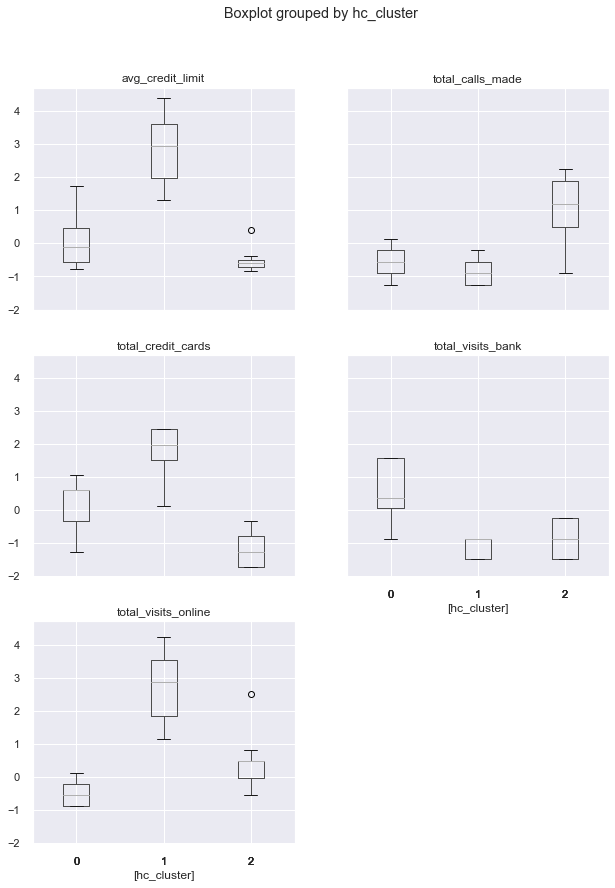

In [55]:
data_scaled_df.boxplot(by='hc_cluster', layout=(3,2), figsize=(10,14));

* If we look at the data we see that there is a group which prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards (cluster - 1).
* The customers who prefer in-person interactions tend to have the mid-range of credit cards and credit limit (cluster - 0).
* The customers who contact via phonecall are in another segment, who have lowest credit limit and number of cards (cluster - 2).

#### Checking the clusters for the duplicated customer keys

In [56]:
data[data['customer_key'].isin(data[data['customer_key'].duplicated()]['customer_key'].tolist())].sort_values('customer_key')

customer_key  avg_credit_limit  total_credit_cards  total_visits_bank  \
Sl_No                                                                          
49            37252              6000                   4                  0   
433           37252             59000                   6                  2   
5             47437            100000                   6                  0   
333           47437             17000                   7                  3   
412           50706             44000                   4                  5   
542           50706             60000                   7                  5   
392           96929             13000                   4                  5   
399           96929             67000                   6                  2   
105           97935             17000                   2                  1   
633           97935            187000                   7                  1   

       total_visits_online  total_calls_made cc_spending_bin  cluster  \
Sl_No                                                                   
49                       2                 8        Very Low        1   
433                      1                 2            High        0   
5                       12                 3            High        2   
333                      1                 0             Low        0   
412                      0                 2             Mid        0   
542                      2                 2            High        0   
392                      0                 0             Low        0   
399                      2                 2            High        0   
105                      2                10             Low        1   
633                      7                 0            High        2   

       hc_cluster  
Sl_No              
49              2  
433             0  
5               1  
333             0  
412             0  
542             0  
392             0  
399             0  
105             2  
633             1

If we consider the duplicate records are actually updated records for the same customer, then it can be observed that 3 of the 5 customers have actually changed their clusters/groups. It appears, providing credit limit increase, or turning the customers to digital banking customers, we can actually move the customers to a more desirable and profitable cluster.

##### Checking the clusters for the duplicated customer keys

In [57]:
data[data['customer_key'].isin(data[data['customer_key'].duplicated()]['customer_key'].tolist())].sort_values('customer_key')

customer_key  avg_credit_limit  total_credit_cards  total_visits_bank  \
Sl_No                                                                          
49            37252              6000                   4                  0   
433           37252             59000                   6                  2   
5             47437            100000                   6                  0   
333           47437             17000                   7                  3   
412           50706             44000                   4                  5   
542           50706             60000                   7                  5   
392           96929             13000                   4                  5   
399           96929             67000                   6                  2   
105           97935             17000                   2                  1   
633           97935            187000                   7                  1   

       total_visits_online  total_calls_made cc_spending_bin  cluster  \
Sl_No                                                                   
49                       2                 8        Very Low        1   
433                      1                 2            High        0   
5                       12                 3            High        2   
333                      1                 0             Low        0   
412                      0                 2             Mid        0   
542                      2                 2            High        0   
392                      0                 0             Low        0   
399                      2                 2            High        0   
105                      2                10             Low        1   
633                      7                 0            High        2   

       hc_cluster  
Sl_No              
49              2  
433             0  
5               1  
333             0  
412             0  
542             0  
392             0  
399             0  
105             2  
633             1

If we consider the duplicate records are actually updated records for the same customer, then it can be observed that 3 of the 5 customers have actually changed their clusters/groups. It appears, providing credit limit increase, or turning the customers to digital banking customers, we can actually move the customers to a more desirable and profitable cluster.

##### Contact method:
A hypothesis that I had going into this was that there would be three clusters for contact method, where customers would stick to their preferred method for interacting with their bank (online, in person, and through the phone). Below we can see a 3D rotating scatter plot which shows my hypothesis was correct.

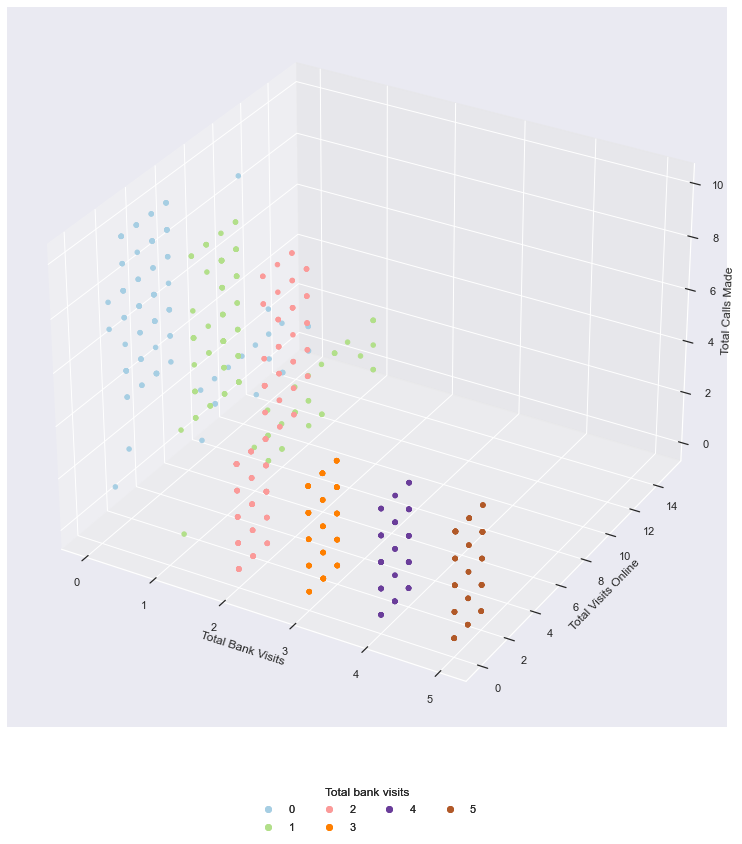

In [58]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(10,10))

ax = Axes3D(fig)



x = data.total_visits_bank
y = data.total_visits_online
z = data.total_calls_made


g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('Total Bank Visits')
ax.set_ylabel('Total Visits Online')
ax.set_zlabel('Total Calls Made')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Total bank visits", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

plt.show()

from matplotlib import animation

def rotate(angle):
     ax.view_init(azim=angle)

angle = 1
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=1)
ani.save('Cluster_plot.gif', writer=animation.PillowWriter(fps=25));


## Actionable insights and Recommendations

###### There appears to be three distinct categories of customers:

* 1.In-person users: prefer to handle bank transactions in person. They have the medium number of credit cards and the medium available credit. They are also the most active users.
* 2.Phone users: prefer verbally handling transactions. They have fewest credit cards and lowest credit card limit.
* 3.Online users: prefer digital transactions. They also have the most credit cards and the highest available credit. Least number of customers have this type of behaviour.

The customer preferences should be used to contact the customers. Online/phone users will probably prefer email/text notifications, while in-person users prefer mail notifications and upselling (when at the bank location).

 Also, the phone and in-person customers should be reached out to promote online banking.